# A simple example of the analysis in Dessert et al. _Science_ 2020

This notebook contains a pedagogical treatment of an example analysis of the stacked data from the MOS camera onboard XMM-Newton in [Dessert et al. _Science_ 2020](https://science.sciencemag.org/content/367/6485/1465). These example analyses can be performed using the data products produced in that reference. In order to make the notebook relatively short and self-contained, we make two simplifications on the dataset we treat.

Firstly, we restrict ourselves to data collected by the MOS data. The reason is that the MOS camera has a simpler instrument response (in particular the PN camera has a variable energy binning). Nevertheless, keep in mind that the data here is only half the story: the PN data produces comparable limits as the MOS data (see the paper).

Secondly, we work with the stacked dataset produced by combining the various MOS exposures. For the main result in Dessert et al. _Science_ 2020, we instead use a joint likelihood approach. The joint likelihood has a variety of advantages relative to stacking the data, as described in the paper. Still, comparable sensitivity is achieved by stacking the data, and as it's the simpler of the two approaches we pursue it here.  However, we _strongly_ recommend the joint likelihood approach for scientific applications.  It is more sensitive than the stacked data approach and also less subject to systematic uncertainties.

In addition to highlighting the results of Dessert et al, a second aim of this notebook is to set the stage for a response to criticisms of this work that have appeared in [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf) and [Boyarsky et al. 2020](https://arxiv.org/pdf/2004.06601.pdf). In particular, we will outline how to modify our formalism to mock up their analysis procedure, leaving a detailed comparison to the companion notebooks.

Finally, if you use the data in this example in a publication, please cite Dessert et al. _Science_ 2020.

**Please direct any questions to bsafdi@umich.edu.**

In [1]:
# Import required modules

%matplotlib inline
%load_ext autoreload
%autoreload 2
 
import sys,os
import numpy as np

from scipy.stats import chi2 as chi2_scipy
from scipy.optimize import dual_annealing
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

**NB**: In this notebook, we minimize with `scipy` so that it is easy to run for the interested reader. For scientific analysis, we recommend [Minuit](https://iminuit.readthedocs.io/en/latest/) or [Multinest](https://github.com/JohannesBuchner/MultiNest) as these minimizers are typically more stable. In our paper, we used Minuit.

# Define signal line energy

By default we will look for an anomalous line at 3.55 keV, as defined by the EUXL parameter below, denoting the energy of the unidentified X-ray line. Lines at different energies can be searched for by changing this parameter accordingly (for example to 3.5 keV). We start with 3.55 keV as this is within the best energy range suggested by [Bulbul et al. _Astrophys. J._ 2014](https://iopscience.iop.org/article/10.1088/0004-637X/789/1/13).

In [2]:
EUXL = 3.55 # [keV]

**NB:** changing EUXL will of course vary the results below, and values in the surrounding discussion will not necessarily be reflective.

# Load in the data and models

First we will load in the data products that we will use in the analysis.  These include the stacked MOS data, associated energy bins, and uncertainties. 

We will use data from two regions of interest (ROI):
- **Signal Region (SR)**: 5-45 degrees from the Galactic Center, this was the fiducial ROI in our main analysis;
- **Background Region (BR)**: 60-90 degrees from the Galactic Center, a useful region for studying background as it contains less dark matter.

In both cases the data represents all exposures in these regions which pass the quality cuts described in Dessert et al. We also load the appropriately averaged D-factors for these two regions (ROIs) for our fiducial NFW profile, along with the respective exposure times.

In [3]:
## Signal Region (5-45 degrees)

# Data, associated errors, and the quiescent particle background
data = np.load("../data/data_mos_sig_ROI.npy") # [cts/s/keV]
data_yerrs = np.load("../data/data_yerrs_mos_sig_ROI.npy") # [cts/s/keV]
QPB = np.load("../data/QPB_mos_sig_ROI.npy") # [cts/s/keV]

# Exposure time
Exp = 23.25e6 # [s]

# D-factor averaged over the signal ROI
D_signal = 5.2e28 # [keV/cm^2]


## Background Region (60-90 degrees)

# Data and associated errors
data_bkg = np.load("../data/data_mos_bkg_ROI.npy") # [cts/s/keV]
data_yerrs_bkg = np.load("../data/data_yerrs_mos_bkg_ROI.npy") # [cts/s/keV]

# Exposure time
Exp_bkg = 67.64e6 # [s]

# D-factor averaged over the background ROI
D_bkg = 1.91e28 # [keV/cm^2]

## Energy binning appropriate for both the signal and background
Energies=np.load("../data/mos_energies.npy") # [keV]

## Plot of the data

Data in the signal region, where the dashed vertical line denotes the location of a putative signal line.

/sw/lsa/centos7/python-anaconda2/2019.03/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


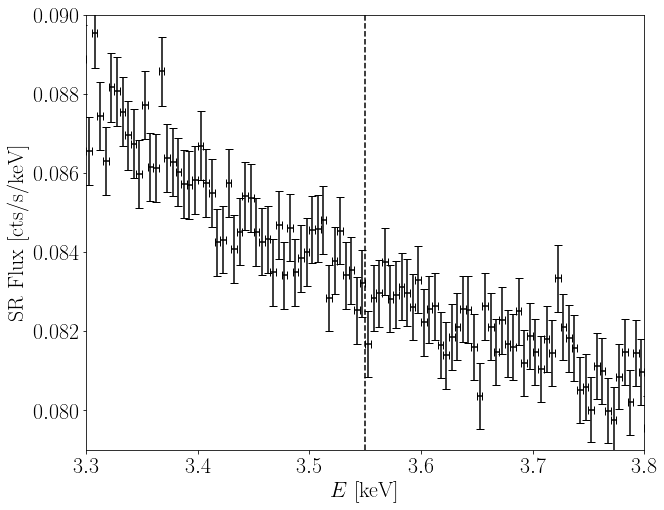

In [4]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.show()

In several examples we will take our signal data and subtract off data from a region well away from the Galactic Center. This background region is the 80-180 degree data loaded above, and will be referred to as the "background" region. One reason for doing this is to check for the possibility that there are instrumental or other background that do not vary as a function of distance from the Galactic Center as the Dark Matter flux will. 

Below, we show the difference between the two datasets.

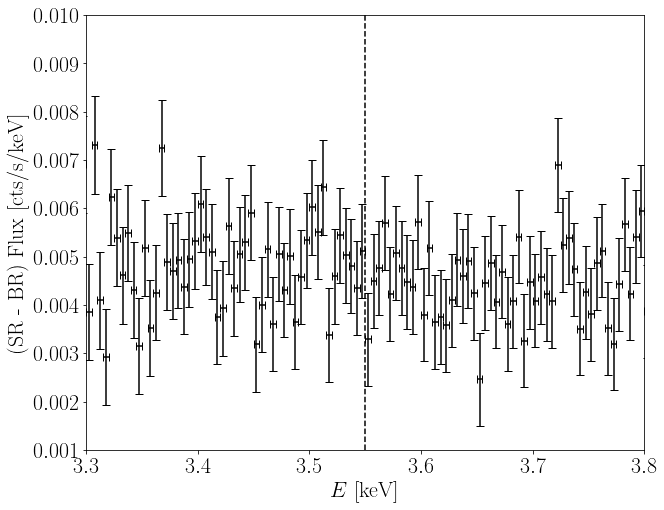

In [5]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2+data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(1e-3,1.e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"(SR - BR) Flux [cts/s/keV]",fontsize=22)
plt.show()

## Load in the Models

Next we use the models that will be used in fitting the above data.

There are a sequence of models corresponding to physical line fluxes at the energies specified by `Es_line`.  That is, `mod_UXL` gives the detectors counts as a function of energy after forward modeling a physical line at EUXL keV with a flux of 1 cts/cm$^2$/s/sr.

In [6]:
# Firstly import 600 precomputed line shapes accounting for the XMM-Newton MOS instrument response
# between 3 and 4 keV
Es_line = np.load("../data/mos_mods_line_energies.npy") # Energies of precomputed lines
mods = np.load("../data/mos_mods.npy") # Model for the lines, all normalized to 1 cts/cm^2/s/sr at the relevant energy

# Extract the closest model to describe a line at E=EUXL
arg_UXL = np.argmin((Es_line-EUXL)**2)
mod_UXL = mods[arg_UXL]
print "The energy of our "+str(EUXL)+" keV line example will be: "+str(Es_line[arg_UXL])+" keV"

# This is an approximate forward-modeling matrix for MOS
det_res = np.load("../data/mos_det_res.npy")

The energy of our 3.55 keV line example will be: 3.5525876460767947 keV


### Aside: what flux do we need to simply over-produce the observed data?

Suppose that we simply wanted to simply not over-produce the data, without any background modelling assumptions.  This leads to a limit of $\sin^2(2\theta) \lesssim 10^{-10}$, as shown below.

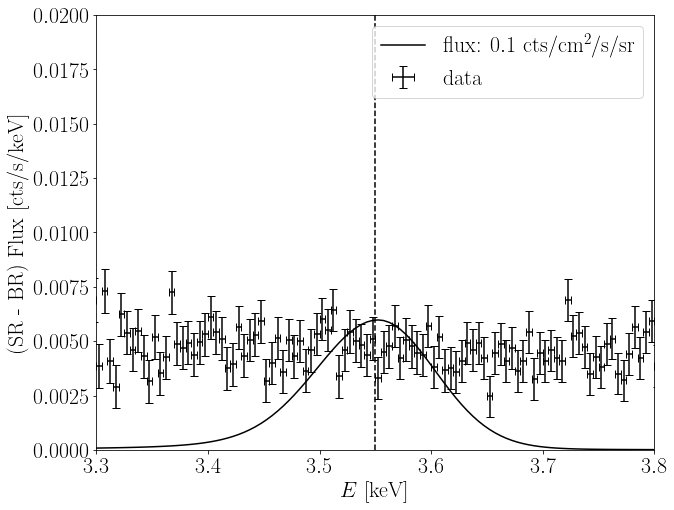

In [7]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-data_bkg,yerr=np.sqrt(data_yerrs**2+data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies,1.e-1*mod_UXL,'k-',label =r"flux: $0.1$ cts/cm$^2$/s/sr")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.3,3.8)
plt.ylim(0,0.02)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"(SR - BR) Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

This plot demonstrates that, regardless of the background modeling, a dark matter signal line with flux brighter than $\sim 0.1$ cts/cm$^2$/s/sr in the signal region versus the background region will overproduce the observed data.  Of course, we will do better than this by modeling the continum emission and also using a statistical analysis, but let's use this example for what value of $\sin^2(2\theta)$ is associated with this flux.

In [8]:
def return_sin_theta_lim(E_line,flux,D_factor):
    """
    D_factor [keV/cm^2]
    flux [cts/cm^2/s/sr]
    E_line [keV] (dark matter mass is twice this value)
    returns: associated sin^2(2theta)
    """
    DMmass = 2.*E_line
    res = (4.*np.pi*DMmass/D_factor)/1.361e-22*(1/DMmass)**5*flux
    return res


print 'The "by eye" limit from the plot above is sin^2(2theta) < '+str(return_sin_theta_lim(EUXL,1.e-1,D_signal-D_bkg))+'.'

The "by eye" limit from the plot above is sin^2(2theta) < 1.10438995027e-10.


This simple exercise demonstrates, that independent of other sources of flux, a value of $\sin^2(2\theta) \lesssim 10^{-10}$ larger than the limit obtained above would simply overproduce the observed data. Interestingly, looking at Fig. 1 of Dessert et al. 2020, this is already a relevant constraint. We will now improve upon this limit by modeling the continuum.

# What would the best-fit lines from 2014 look like here?

Continuing with a simplified analysis, let's just have a look at how the 3.5 keV line detected in other astrophysical objects would appear in our dataset. Firstly we plot the dataset from 3-4 keV for both our signal and background regions.

In [9]:
ref_lim_signal = return_sin_theta_lim(3.55,0.1,D_signal)
ref_lim_bkg = return_sin_theta_lim(3.55,0.1,D_bkg)

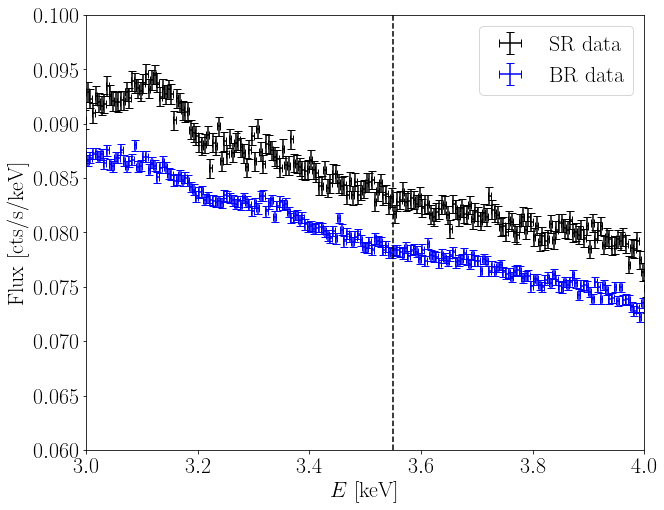

In [10]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=np.sqrt(data_yerrs**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="SR data",marker="o", fmt='none',capsize=4)
plt.errorbar(Energies,data_bkg,yerr=np.sqrt(data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="blue",label="BR data",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(6.e-2,1.e-1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Note already in this data, lines are visible. For example, the line visible at 3.1 keV is likely associated with Ar XVII.

Continuing, let's start with the intensity of line detected in the MOS Perseus analysis of [Bulbul et al. _Astrophys. J._ 2014](https://iopscience.iop.org/article/10.1088/0004-637X/789/1/13), where they found $\sin^2(2\theta) \sim 5 \times 10^{-10}$. This corresponds to fluxes of 0.7 and 0.16 cts/cm$^2$/s/sr in our signal and background regions respectively, which is straightforward to confirm using `return_sin_theta_lim` defined above.

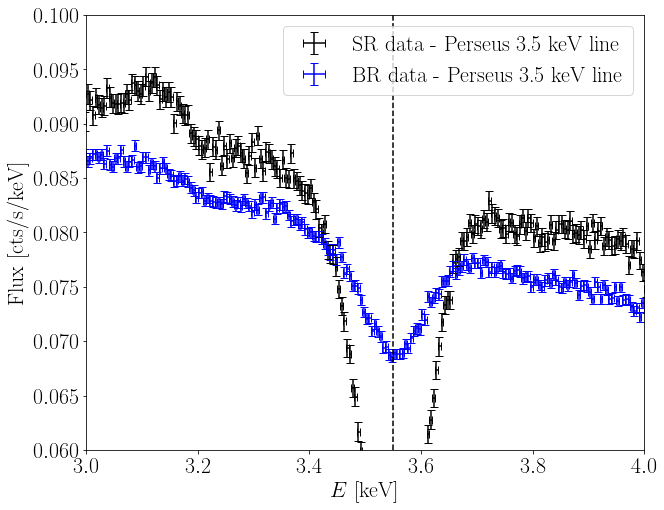

In [11]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-0.7*mod_UXL,yerr=np.sqrt(data_yerrs**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="SR data - Perseus 3.5 keV line",marker="o", fmt='none',capsize=4)
plt.errorbar(Energies,data_bkg-0.16*mod_UXL,yerr=np.sqrt(data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="blue",label="BR data - Perseus 3.5 keV line",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(6.e-2,1.e-1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Clearly the presence of this line would be a significant feature in the dataset if present with that mixing angle.

The Perseus value is an outlier in the detected signal strengths. If instead we consider the intensity attributed to the stacked cluster analysis of [Bulbul et al. _Astrophys. J._ 2014](https://iopscience.iop.org/article/10.1088/0004-637X/789/1/13), here the best fit value was $\sin^2(2\theta) \sim 7 \times 10^{-11}$. This now corresponds to fluxes of 0.1 and 0.023 cts/cm$^2$/s/sr in our signal and background regions respectively, and would have an impact as depicted below.

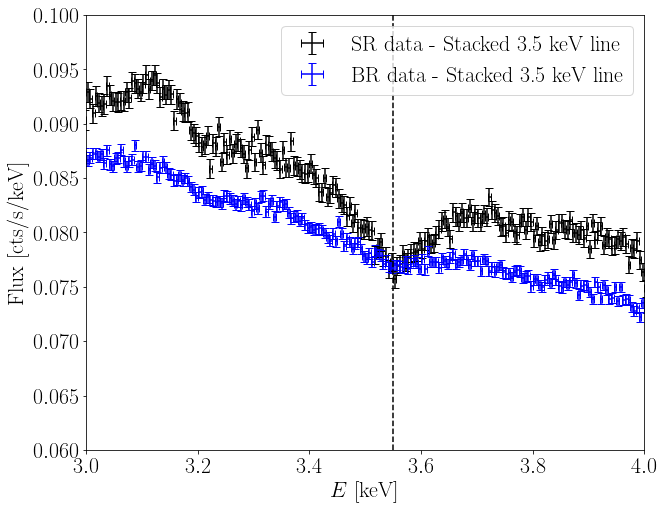

In [12]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-0.1*mod_UXL,yerr=np.sqrt(data_yerrs**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="SR data - Stacked 3.5 keV line",marker="o", fmt='none',capsize=4)
plt.errorbar(Energies,data_bkg-0.023*mod_UXL,yerr=np.sqrt(data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="blue",label="BR data - Stacked 3.5 keV line",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(6.e-2,1.e-1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Now the deviation in the background dataset is less pronounced, but a clear feature would still be present in the signal region.

As a final example of a case between the above two, in [Cappelluti et al _Astrophys. J._ 2018](https://iopscience.iop.org/article/10.3847/1538-4357/aaaa68/meta) a line was detected in the Chandra deep field with $\sin^2(2\theta) \sim 1.5 \times 10^{-10}$, or a signal and background flux in our regions of 0.22 and 0.05 cts/cm$^2$/s/sr. This would have the following impact on the data.

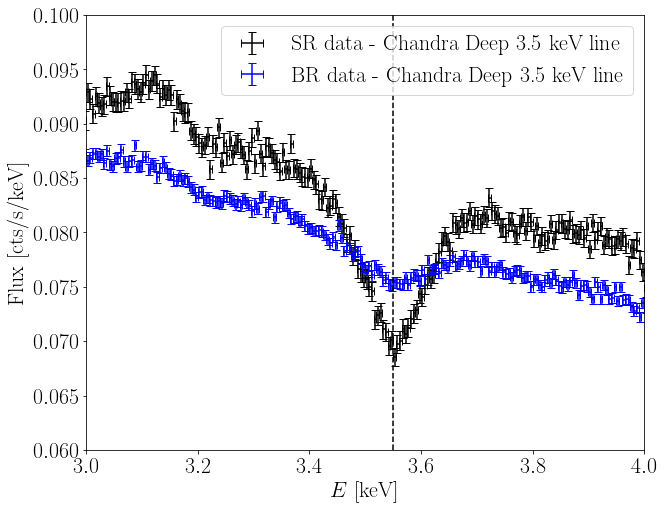

In [13]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data-0.22*mod_UXL,yerr=np.sqrt(data_yerrs**2),
             xerr=(Energies[1]-Energies[0])/2.,color="black",label="SR data - Chandra Deep 3.5 keV line",marker="o", fmt='none',capsize=4)
plt.errorbar(Energies,data_bkg-0.05*mod_UXL,yerr=np.sqrt(data_yerrs_bkg**2),
             xerr=(Energies[1]-Energies[0])/2.,color="blue",label="BR data - Chandra Deep 3.5 keV line",marker="o", fmt='none',capsize=4)
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(3.0,4.0)
plt.ylim(6.e-2,1.e-1)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Again the impact is clear.

According, if the 3.5 keV line is a result of sterile neutrino dark matter decay, it should produce a dramatic effect in our signal dataset. We will explore in detail below whether such a line is in fact preferred.

# Statistical analysis

Now, let's perform a rigorous statistical analysis, using profile likelihood. As we operate in the large counts limit for the stacked data, we can perform a simple $\chi^2$ analysis rather than a full joint likelihood analysis as used by default in Dessert et al. 2020.

**NB:** we will model the background over this narrow region as a simple featureless polynomial. In particular, we choose a quadratic function as used for the stacked analysis in Dessert et al. 2020. Nevertheless, similar results are obtained for a simple power law or most other smooth functions. Users are encouraged to try alternative models.

In [14]:
## Define the functions we will use

class chi2:
    """ A set offunctions for calculation the chisq associated with different hypotheses
    """
    def __init__(self,ens,dat,err,null_mod,sig_template):
        self._ens = ens
        self._dat = dat
        self._err = err
        self._null_mod = null_mod
        self._sig_template = sig_template
        self._A_sig = 0.0
    
    def chi2(self,x):
        null_mod = self._null_mod(self._ens,x[1:])
        sig_mod = self._sig_template*x[0]
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2)
    
    def chi2_null(self,x):
        null_mod = self._null_mod(self._ens,x)
        return np.sum((self._dat - null_mod)**2/self._err**2)
    
    def chi2_fixed_signal(self,x):
        null_mod = self._null_mod(self._ens,x)
        sig_mod = self._sig_template*self._A_sig
        return np.sum((self._dat - null_mod - sig_mod)**2/self._err**2) 
    
    def fix_signal_strength(self,A_sig):
        self._A_sig = A_sig
        
def mod_poly(ens,x):
    """ A simple polynomial model for the background
    """
    A, B, C = x
    return A+B*ens + C*ens**2

## Fit within $E_{\rm UXL} \pm 0.25$ keV

First, we will fit the models from $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV. Later in this notebook, we broaden this range to 3.0 to 4.0 keV. For the default $E_{\rm UXL} = 3.55$ keV, this correspond to $3.3~{\rm keV} < E < 3.8~{\rm keV}$.

To begin with then, let's reduce the dataset to this restricted range.

In [15]:
whs_reduced = np.where((Energies >= EUXL-0.25) & (Energies <= EUXL+0.25))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

Next, let's fit this data with the background only hypothesis and consider the quality of fit.

In [16]:
# Compute the best fit parameters by minimising the chisq

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly,mod_UXL_reduced)

mn_null = minimize(chi2_instance.chi2_null,np.array([0.3,-0.1,0.01]),method='Nelder-Mead')

print "Best fit background parameters:",mn_null.x
print "The chi^2/DOF of the null-model fit is :", mn_null.fun/(len(whs_reduced)-3.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)
print "Expected 99% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.99,len(whs_reduced)-3.))/float(len(whs_reduced)-3.)

Best fit background parameters: [ 0.37631572 -0.15090723  0.01924884]
The chi^2/DOF of the null-model fit is : 0.6992638654485737
Expected 68% containment for the chi^2/DOF: [0.85762331 1.14223123]
Expected 99% containment for the chi^2/DOF: [0.66884508 1.40843894]


So, in this example the null model is a really good fit! It is actually such a good fit that the $\chi^2 / {\rm DOF}$ is outside of the 68% expectation, though it is within the 99% expectation.

Next, let's see how much a line at EUXL can improve upon this fit.

In [17]:
# Compute the best fit parameters by minimising the chisq

mn = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2]]),method='Nelder-Mead')

print "Best fit signal+background parameters:", mn.x
print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun

Best fit signal+background parameters: [ 9.98022179e-05  3.76494812e-01 -1.51017891e-01  1.92657176e-02]
The Delta chi^2 between signal and null model is: 0.00040524037756028974


The $\Delta \chi^2$ between the signal and null models, which are nested with the signal model having one additional DOF, is tiny (~0.0004). As such setting a limit rather than claiming a discovery for a line at this energy is appropriate. We will turn to the question of limit setting in the next section.

To help visualise these results, below we plot the best fit background.

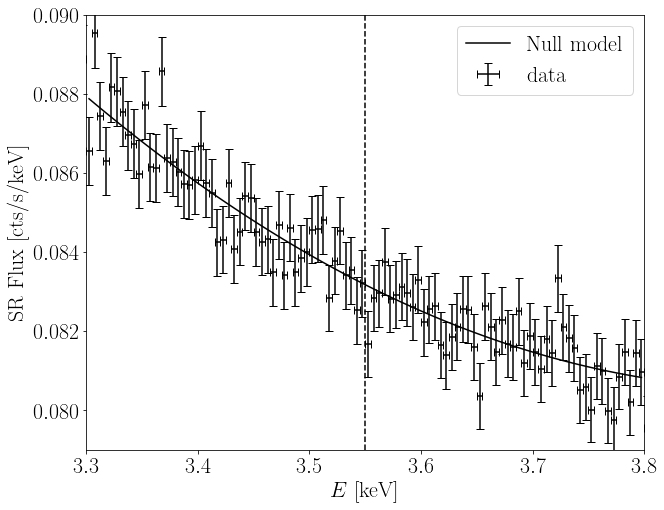

In [18]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,color="black",
             label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly(Energies_reduced,mn_null.x),'k-',label =r"Null model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(7.9e-2,9e-2)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

## Profile likelihood

Now, let's construct the profile likelihood to get an approximate 95\% upper limit. The qualifier approximate applies as we are going to assume Wilks' theorem and simply look for values of the signal parameter for which the profile likelihood rises above ~2.71 from the minimum.  To be completely rigorous, the actual limit should be constructed from MC simulations.

In order to determine where this occurs, we calculate the likelihood at several fixed values of the signal flux, starting at the best fit value determined above. In each case we refloat the background as required by the profile likelihood.

In [19]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun
    
amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.010684692656490455 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 7.465811742366445e-12


So, we see that modeling the background and using a statistical analysis gives us an improved limit relative to simply not overshooting the data (by a factor ~10 - 20).  Below, we plot the profile likelihood.

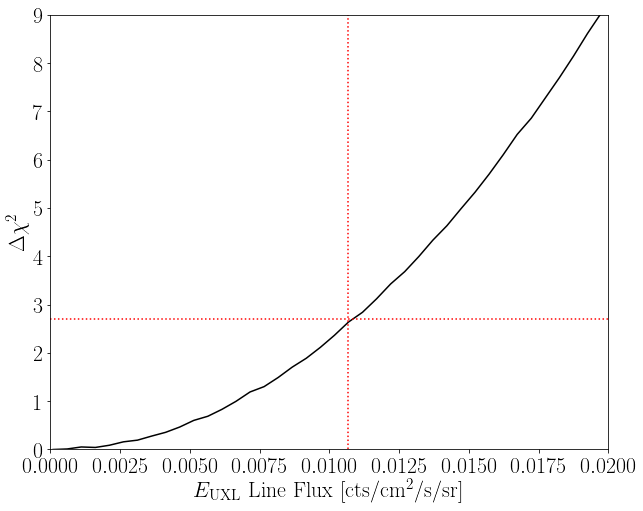

In [20]:
fig = plt.figure(figsize=(10,8))
plt.plot(A_sig_array,chi2_sig_array-chi2_sig_array[0],'k-')
plt.axhline(2.71,color="red",linestyle="dotted")
plt.axvline(limit_signal_strength,color="red",linestyle="dotted")
plt.xlim(mn.x[0],limit_signal_strength*2.)
plt.ylim(0,9)
plt.xlim(0,0.02)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E_{\rm UXL}$ Line Flux [cts/cm$^2$/s/sr]",fontsize=22)
plt.ylabel(r"$\Delta \chi^2$",fontsize=22)
plt.show()

# Turning towards Boyarsky et al.

The above represents a simplified version of the analysis which appeared in Dessert et al. _Science_ 2020, designed to provide some intuition for the strength of the limit produced there and the physics that went into deriving it. Again, we remind that in the actual analysis we used a joint likelihood rather than a stacking, and we included data from the PN and MOS cameras.

The stacking approach used above, however, was the central method employed in [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf) and more recently in a comment on our work in [Boyarsky et al. 2020](https://arxiv.org/pdf/2004.06601.pdf). As we turn towards responding to the claims made in those works, we can extend the formalism developed above towards their methodology.

Our first step is to include additional background lines.

## Extending the background model to include additional lines

Let's now suppose that the background model contains additional degrees of freedom beyond those considered above. In particular, we consider the possibility that there are lines at 3.3 keV and 3.7 keV, as has been suggested in, for example, [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf). Evidence for instrumental lines at these energies in the PN camera has been presented in the detailed detector study of [Struder et al. _Nucl. Instrum. Methods Phys. Res._ 2003](https://ui.adsabs.harvard.edu/abs/2003NIMPA.512..386S/abstract). However, as we are only considering the MOS camera here, no instrumental lines at these energies exist. Plasma emission lines exist at these energies, and in principle those lines could appear in our data at a low level.

Regardless, we can always include these extra lines in our analysis and test whether evidence for a 3.5 keV line appear in this case. Note that ahead of time we expect a weaker limit to result from this analysis, as there will be an enhanced degeneracy between the signal and background models.

In [21]:
arg_3p3 = np.argmin((Es_line-3.32)**2)
mod_3p3 = mods[arg_3p3]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

def mod_poly_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, B, C, S1, S2 = x

    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.282,-0.098, 0.011,0.1,0.1]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3],mn_null_line.x[4]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-5.)

print "Expected 68% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.68,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)
print "Expected 99% containment for the chi^2/DOF:", np.array(chi2_scipy.interval(0.99,len(whs_reduced)-5.))/float(len(whs_reduced)-5.)

The Delta chi^2 between signal and null model is: 2.21070365523326
The chi^2/DOF of the null-model fit is: 0.721824594625385
Expected 68% containment for the chi^2/DOF: [0.85614219 1.14370943]
Expected 99% containment for the chi^2/DOF: [0.66578577 1.41312157]


The inclusion of additional lines has not changed our conclusion. The null model is still a good fit to the data, and the best-fit signal strength is still consistent with zero at $\sim$1$\sigma$.

Next we plot the best fit signal and background model, in particular we see the model is almost identical in the two cases, emphasizing the lack of preference for a new emission line at 3.55 keV in this dataset.

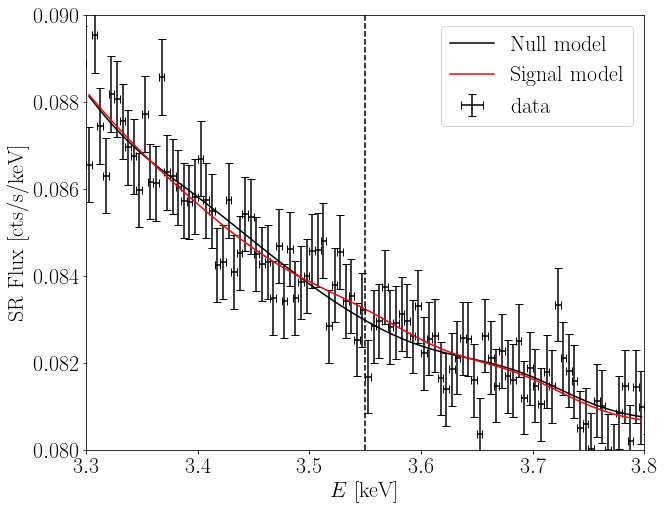

In [22]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_poly_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.08,0.09)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally let's compute the associated limit via profile likelihood.

In [23]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.01744334983968475 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.2188349281176217e-11


Note that including the background lines has made the limit on $\sin^2(2\theta)$ in this case slightly weaker (from $7\times 10^{-12}$ to $1.2 \times 10^{-11}$).  In general one finds a slight decrease in sensitivity due to the additional background parameters.  Note that this limit is consistent with that at $m_s = 7.1$ keV in Fig. S14 of Dessert et al. 2020, though again we stress that that plot was constructed from the joint likelihood.

## Powerlaw background model

In the above we model the background using a simple polynomial. Boyarsky et al instead use a power law, and we'll revise our appraoch to use this background model next. Note that while for an individual observation of the blank sky we might expect a power law to represent a physical description of the data, once we stack many analyses together this will begin to break down: the sum of a series of power law is not in general another power law. This emphasizes again the importance of the joint likelihood procedure. Nevertheless, with a view of moving towards Boyarsky's analysis we will change the background model. In practice, for this analysis we will find it gives a similar result to the above.

Firstly, let's look at the signal and background models, and how much the former is preferred over the latter.

In [24]:
def mod_power_two_lines(ens,x):
    "An extended background model to include two additional lines"
    A, n, S1, S2 = x

    return A*ens**n + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_two_lines,mod_UXL_reduced)

mn_null_line = minimize(chi2_instance.chi2_null,np.array([0.15626353, -0.49661547, 0.02459556, -0.00120595]),method='Nelder-Mead')

mn_line = minimize(chi2_instance.chi2,np.array([1.e-2,mn_null_line.x[0],mn_null_line.x[1],mn_null_line.x[2],mn_null_line.x[3]]),method='Nelder-Mead',options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})


print "The Delta chi^2 between signal and null model is:", mn_null_line.fun - mn_line.fun
print "The chi^2/DOF of the null-model fit is:", mn_null_line.fun/(len(whs_reduced)-4.)

The Delta chi^2 between signal and null model is: 0.475487386219811
The chi^2/DOF of the null-model fit is: 0.699915009796166


For a power-law background model the preference for a signal is still marginal, and in fact even reduced as compared to the polynomial background. This is reflected in a plot of the two models.

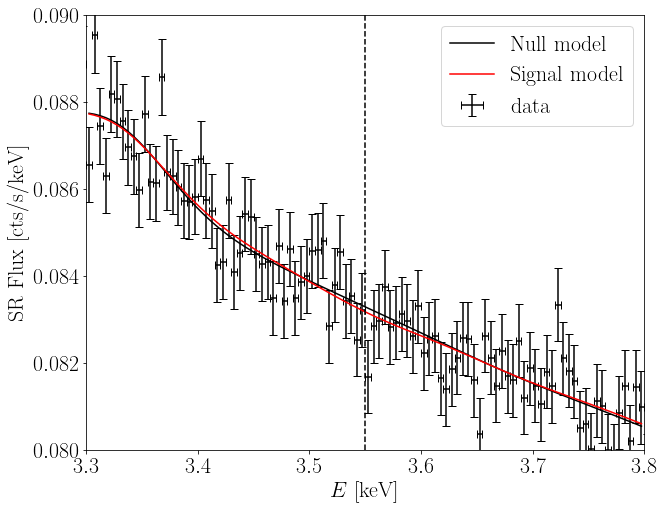

In [25]:
fig = plt.figure(figsize=(10,8))
plt.errorbar(Energies,data,yerr=data_yerrs,xerr=(Energies[1]-Energies[0])/2.,
             color="black",label="data",marker="o", fmt='none',capsize=4)
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_null_line.x),'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_power_two_lines(Energies_reduced,mn_line.x[1:])+mn_line.x[0]*mod_UXL_reduced,
         'r-',label =r"Signal model")
plt.axvline(EUXL,color="black",linestyle="dashed")
plt.xlim(EUXL-0.25,EUXL+0.25)
plt.ylim(0.08,0.09)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally let's compute the limit.

In [26]:
A_sig_array = np.linspace(mn_line.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn_line.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.004938631785829827 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 3.4508147649408644e-12


For this background model, the limit on the UXL is now even stronger. This is consistent with the reduced preference for the signal model.

# Is there something special about $[E_{\rm UXL}-0.25,\,E_{\rm UXL}+0.25]$ keV?

No.  We used a narrow energy range to mitigate possible systematic issues due to imperfections in the null model, but this doesn't mean that we find qualitatively different results if we were to use a wider energy range.  Let's explore the energy range from 3.0 to 4.0 keV.

As pointed out in e.g. [Boyarsky et al. 2018](https://arxiv.org/pdf/1812.10488.pdf), there is a large astrophysical line at ~3.1 keV and also at ~3.9 keV.  We will include both of these lines, in addition to the 3.3 and 3.7 keV lines included above.

Our procedure is as follows. Firstly, we update the dataset. Then we will define a new background model incorporating these additional lines. Finally we repeat our default $\chi^2$ fit procedure.

**NB:** in order to improve the stability of fits over this larger region, we swap from scipy minimize to dual_annealing to determine the best fit models. For speed only, when performing the profile likelihood we continue to use minimize.

In [27]:
# Reduce the data to the larger energy range
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) 
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]


def mod_power_four_lines(ens,x):
    A, n, S1, S2, S3, S4 = x
    return A*ens**n + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_power_four_lines,mod_UXL_reduced)

x0 = np.array([ 0.1700395,  -0.56524135 , 0.0192543  , 0.00712197,  0.06653334 , 0.02087408])
bounds = np.array([[1e-6,5],[-3,0],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

boundss = np.array([[-0.5,0.5],[1e-6,5],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

The Delta chi^2 between signal and null model is: 0.14884904348173222
The chi^2/DOF of the null-model fit is: 0.7683767821793943


Again, we compute the limit in this case using the by now familiar procedure.

In [28]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.00906741541702023 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 6.335757018914552e-12


In this particular case, the limit is a factor of 2 weaker than what we obtained in the smaller energy range. Despite the weaker, we caution that going to a larger energy range increases the systematic uncertainties, since it is less clear that the null model can describe the data over the full energy range in this case.  This is why we use a narrower energy range.

Before plotting, let's consider adding a UXL with a noarmalization fixed to a conservative interpretation of previous detections. For this purpose, we consider the Chandra detection in the Milky Way halo by [Cappelluti 2017](https://arxiv.org/pdf/1701.07932.pdf). To be conservative, we take a 2$\sigma$ downward fluctuation in their central value, giving a mixing angle of $\sin^2(2\theta) \sim 4.8 \times 10^{-11}$.

In [29]:
# Determine the associated flux
flux_illustrative = 4.8e-11 / return_sin_theta_lim(EUXL,1.,D_signal)*1.

# Determine the chi2
chi2_instance.fix_signal_strength(flux_illustrative)
mn_f = dual_annealing(chi2_instance.chi2_fixed_signal,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

# Compare to the null
print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn_f.fun

The Delta chi^2 between signal and null model is: -217.85351105186993


As we can see the fit is considerably worse in this case. Let's plot all three models. As there are a large number of data points, we will average the data. We emphasize this is for plotting purposes only - we did not average in the above analysis.

We will see that while the model with the illustrative flux value is considerably different, there are only subtle variations between the best fit signal and null models in these cases.

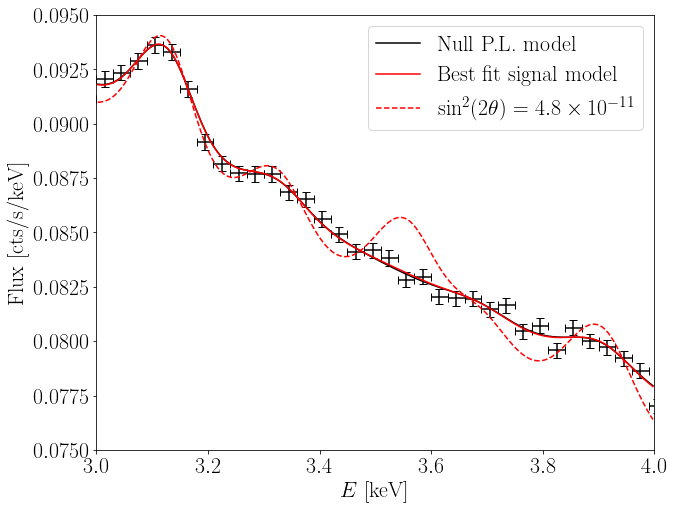

In [30]:
def avg_data(data,n):
    return np.mean(data.reshape(-1, n), axis=1)

fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
plt.plot(Energies_reduced,mod_power_four_lines(Energies_reduced,mn_f.x)+chi2_instance._A_sig*mod_UXL_reduced,
         'r--',label =r"$\sin^2(2\theta) = 4.8 \times 10^{-11}$")

plt.xlim(3,4)
plt.ylim(0.075,0.095)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

Finally, we compute the limit in this case.

In [31]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.00906741541702023 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 6.335757018914552e-12


## Now with a polynomial background

What is we instead used the polynomial background in this case, as we did earlier in the notebook?

In [32]:
whs_reduced = np.where((Energies >= 3.0) & (Energies <= 4.0))[0]
Energies_reduced = Energies[whs_reduced]
data_reduced = data[whs_reduced]
data_yerrs_reduced = data_yerrs[whs_reduced]
data_bkg_reduced = data_bkg[whs_reduced]
data_yerrs_bkg_reduced = data_yerrs_bkg[whs_reduced]
mod_UXL_reduced = mod_UXL[whs_reduced]

arg_3p1 = np.argmin((Es_line-3.12)**2) #3.12 #should really be 3.128
mod_3p1 = mods[arg_3p1]

arg_3p9 = np.argmin((Es_line-3.90)**2)
mod_3p9 = mods[arg_3p9]

arg_3p7 = np.argmin((Es_line-3.68)**2)
mod_3p7 = mods[arg_3p7]

arg_3p3 = np.argmin((Es_line-3.32)**2) 
mod_3p3 = mods[arg_3p3]

def mod_poly_four_lines(ens,x):
    A, B, C,S1, S2, S3, S4 = x
    return A+B*ens + C*ens**2 + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_poly_four_lines,mod_UXL_reduced)


x0 = np.array([ 0.1668137 , -0.033764    ,0.00286752 , 0.01858535 , 0.00754973 , 0.06651711,
  0.02174271])
bounds = np.array([[-1,1],[-1,1],[-1,1],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

boundss = np.array([[-0.5,0.5],[-1,1],[-1,1],[-1,1],[0,0.1],[0,0.1],[0,0.1],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

The Delta chi^2 between signal and null model is: 0.11492761605978785
The chi^2/DOF of the null-model fit is: 0.7709714497404917


As usual, let's plot and determine the limit. Again note we only average in plotting, not in the analysis.

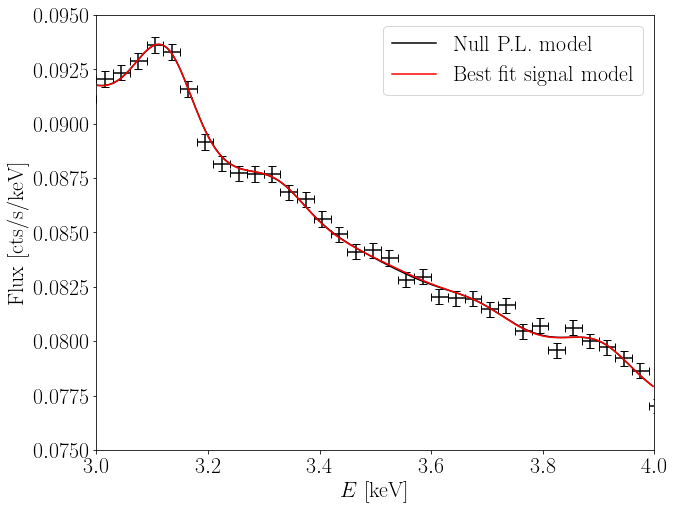

In [33]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) 

plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")
plt.plot(Energies_reduced,mod_poly_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)
plt.ylim(0.075,0.095)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [34]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead',
                          options={'fatol':1e-10,'xatol':1e-10,'adaptive':True})
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.008887725381552003 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 6.21020057850819e-12


The limit in this case is almost identical to what we found using the power law model.

## Subtract background

To provide a different analysis, we can subtract the data taken far away from the Galactic Center. The motivation is that as the DM flux should be reduced here, this subtraction will remove systematics, but leave a putative signal line.

The remaining flux should be astrophysical in origin to the extent the detector background agrees between the two regions. Given this, we model the background now by a power law folded through the detector response.

In [35]:
# A folded powerlaw function
def folded_PL(A,n):
    mod_F = np.matmul(det_res,A*Energies**n) 
    return mod_F

def mod_folded_power_four_lines(ens,x):
    A, n,S1, S2, S3, S4 = x
    return folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced- data_bkg[whs_reduced],np.sqrt(data_yerrs_reduced**2+data_yerrs_bkg_reduced**2),mod_folded_power_four_lines,mod_UXL_reduced)

x0 = np.array([0.00798376, -0.33538497, 0.00554641, 0.00133136, 0.04096368, 0.01195946])
bounds = np.array([[1e-6,5],[-3,0],[0,0.5],[0,0.5],[0,0.5],[0,0.5]])
mn_null = dual_annealing(chi2_instance.chi2_null,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

boundss = np.array([[-0.5,0.5],[1e-6,5],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.2]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5]])
mn = dual_annealing(chi2_instance.chi2,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=500)

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun
print "The chi^2/DOF of the null-model fit is:", mn_null.fun/(len(whs_reduced)-6.)

The Delta chi^2 between signal and null model is: 1.6685253199883903
The chi^2/DOF of the null-model fit is: 0.86337884231339


Let's look at the best fit values and the associated limit.

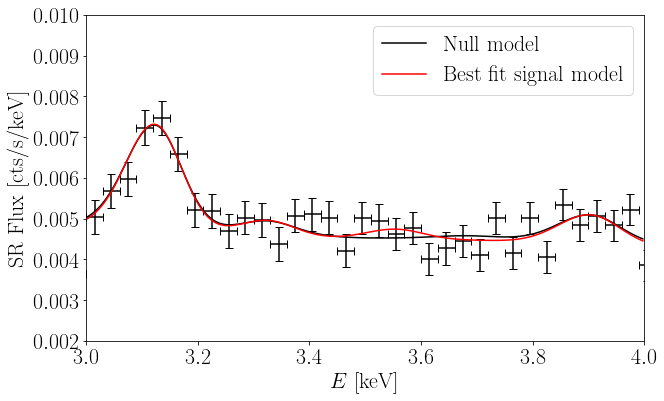

In [36]:
fig = plt.figure(figsize=(10,6))

plt.errorbar(avg_data(Energies,6),avg_data(data-data_bkg,6),yerr=np.sqrt(6*avg_data(data_yerrs**2+data_yerrs_bkg**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"

plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null model")
plt.plot(Energies_reduced,mod_folded_power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")

plt.xlim(3,4)
plt.ylim(0.002,0.01)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"SR Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [37]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]

print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal-D_bkg)

The 95% upper limit on the signal flux is 0.012022379759435702 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 1.3277395384684561e-11


So yet again we find no significant evidence for the UXL, and the derived limit strongly constrains the conventional decaying dark matter interpretation.

# Adding in QPB

So far in these simple examples we have made no attempt to model or include the QPB. In Dessert et al. this was included, and as we work towards comparing with Boyarsky et al we now discuss how to incorporate this instrumental background.

The QPB data is complicated because it is correlated from observation to observation.  Thus, summing the data leads to correlated uncertainties. This can be accounted for in a joint likelihood procedure carefully, but when stacking we need some method to account for the correlated errors. Here we pursue a data-driven approach of fixing the normalization of the $\chi^2$ function such that the powerlaw gives the expected $\chi^2/{\rm DOF}$.

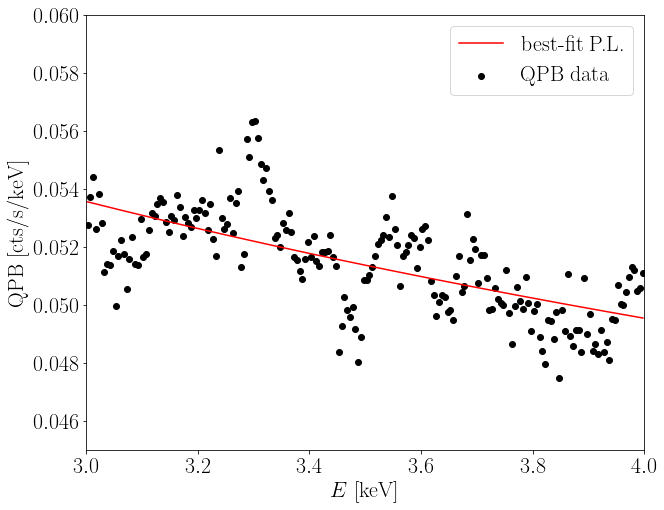

In [38]:
# We are going to fix a powerlaw to the QPB data and then renormalize the chi^2 function
def PL(A,n,ens):
    return A*ens**n

def chi2_QPB_UN(x):
    A,n = x
    mod = PL(A,n,Energies_reduced)
    return np.sum((mod-QPB[whs_reduced])**2)

mn_QPB = minimize(chi2_QPB_UN,[0.084,-0.20],method="Nelder-Mead")
bf_QPB=mn_QPB.x

chi2_not_reduced = chi2_QPB_UN(bf_QPB)

# The function below has the expected normalization
chi2_QPB = lambda x: chi2_QPB_UN(x)/chi2_not_reduced*((len(QPB[whs_reduced])-2.))

fig = plt.figure(figsize=(10,8))
plt.scatter(Energies_reduced,QPB[whs_reduced],marker="o",color="black", label='QPB data')
plt.plot(Energies_reduced,PL(bf_QPB[0],bf_QPB[1],Energies_reduced),'r-',label="best-fit P.L.")
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"QPB [cts/s/keV]",fontsize=22)
plt.xlim(3,4)
plt.ylim(0.045,0.06)
plt.legend(fontsize=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

With this new model, let's perform an analysis where we model the data and the QPB.

In [39]:
def mod_2power_four_lines(ens,x):
    AQPB, nQPB,A, n,S1, S2, S3, S4 = x
    return PL(AQPB,nQPB,ens)+ folded_PL(A,n)[whs_reduced] + S1*mod_3p3[whs_reduced] \
           + S2*mod_3p7[whs_reduced]+ S3*mod_3p1[whs_reduced] + S4*mod_3p9[whs_reduced]

chi2_instance = chi2(Energies_reduced,data_reduced,data_yerrs_reduced,mod_2power_four_lines,mod_UXL_reduced)

x0 = np.array([ 0.07269779, -0.27658551 , 0.13880997, -1.039937  ,  0.02132077 , 0.00150909, 0.06295034,  0.01520248])
bounds = np.array([[0.75*bf_QPB[0],1.25*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.1]])

# Below is the joint likelihood for the null model
def joint_chi2(x):
    return chi2_QPB(x[:2])+chi2_instance.chi2_null(x)

mn_null = dual_annealing(joint_chi2,x0=x0,bounds=bounds,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=100)

# Below is the joint likelihood for the signal model
def joint_chi2_sig(x):
    return chi2_QPB(x[1:3])+chi2_instance.chi2(x)

boundss = np.array([[-0.5,0.5],[0.5*bf_QPB[0],2*bf_QPB[0]],[-1,0],[0.0001,2.0],[-3,0],[0,0.1],[0,0.1],[0,0.1],[0,0.1]])
x0s=np.array([1.e-2,mn_null.x[0],mn_null.x[1],mn_null.x[2],mn_null.x[3],mn_null.x[4],mn_null.x[5],mn_null.x[6],mn_null.x[7]])
mn = dual_annealing(joint_chi2_sig,x0=x0s,bounds=boundss,local_search_options={"method": "Nelder-Mead"},seed=1234,maxiter=100)

print "The Delta chi^2 between signal and null model is:", mn_null.fun - mn.fun

The Delta chi^2 between signal and null model is: 0.7429619331992399


One last time, let's plot the two spectra and calculate the limit.

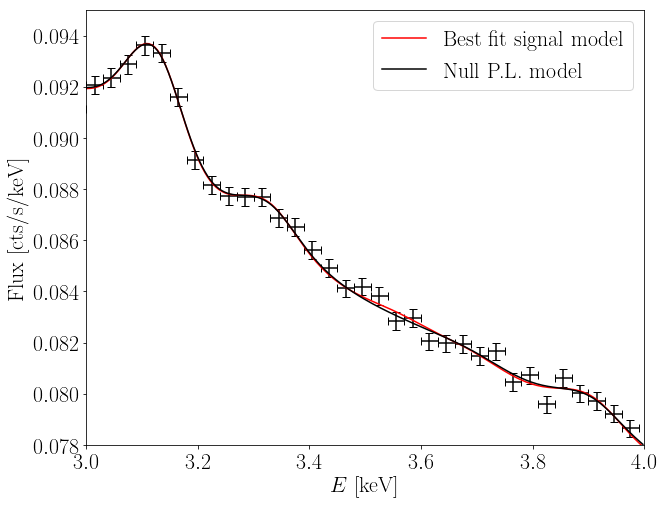

In [40]:
fig = plt.figure(figsize=(10,8))

plt.errorbar(avg_data(Energies,6),avg_data(data,6),yerr=np.sqrt(6*avg_data(data_yerrs**2,6))/6.,xerr=6*(Energies[1]-Energies[0])/2.,
             color="black",marker="o", fmt='none',capsize=4) #label="data"

plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn.x[1:])+mn.x[0]*mod_UXL_reduced,
         'r-',label =r"Best fit signal model")
x0 = np.array([bf_QPB[0],bf_QPB[1], 0.064218, -0.4306988 , 0.02542355 , 0.01451921 , 0.09027154,  0.03331636])
plt.plot(Energies_reduced,mod_2power_four_lines(Energies_reduced,mn_null.x),
         'k-',label =r"Null P.L. model")

plt.xlim(3,4)
plt.ylim(0.078,0.095)

plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel(r"$E$ [keV]",fontsize=22)
plt.ylabel(r"Flux [cts/s/keV]",fontsize=22)
plt.legend(fontsize=22)
plt.show()

In [41]:
A_sig_array = np.linspace(mn.x[0],0.05,100)
chi2_sig_array = np.zeros(len(A_sig_array))
bf = mn.x[1:]
for i in range(len(A_sig_array)):
    chi2_instance.fix_signal_strength(A_sig_array[i])
    mn_profile = minimize(chi2_instance.chi2_fixed_signal,bf,method='Nelder-Mead')
    bf = mn_profile.x
    chi2_sig_array[i] = mn_profile.fun

amin = np.argmin((chi2_sig_array-chi2_sig_array[0] - 2.71)**2)
limit_signal_strength = A_sig_array[amin]
print "The 95% upper limit on the signal flux is", limit_signal_strength, "cts/cm^2/s/sr"
print "This corresponds to a limit on sin^2(2theta) of", return_sin_theta_lim(EUXL,limit_signal_strength,D_signal)

The 95% upper limit on the signal flux is 0.011381817883326139 cts/cm^2/s/sr
This corresponds to a limit on sin^2(2theta) of 7.952920344526205e-12


Although modelling the QPB brings us closer to the analysis of Dessert et al., we see the conclusion reached is comparable to the results seen so far.

In the next two notebooks, we will use the tools introduced above to study the claims and concerns raised in Boyarsky et al.